In [ ]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
import eli5
from tqdm import tqdm

In [ ]:
df_train = pd.read_hdf("C:/Users/48794/Downloads/df.train.h5")
print(df_train.shape)

df_train.sample(5)

(80129, 10)


,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params
141222,141222,"Cena Brutto, Faktura VAT",182 000,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...","Duda-Cars S.A., dealer Mercedes-Benz i Smart, ...",Dealer,"ul. Balonowa 55 - 64-100 Leszno, Wielkopolskie...","[Osobowe, Mercedes-Benz, Klasa S, S 350, Merce...","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ..."
57916,57916,"Cena Netto, Faktura VAT",19 900,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",autov-max,Dealer,"krzyszkowice 1305 - 32-445 Krzyszkowice, myśle...","[Osobowe, Seat, Ibiza, Seat Ibiza IV (2008-2017)]","{'Liczba miejsc': '2', 'Homologacja ciężarowa'..."
130890,130890,"Cena Brutto, Do negocjacji",9 500,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",AUTO - PROFIT,Dealer,"ul. Szpakowa 21 - 59-220 Legnica, Dolnośląskie...","[Osobowe, Nissan, Micra, Nissan Micra K12 (200...","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ..."
107619,107619,"Cena Brutto, Do negocjacji, Faktura VAT",26 999,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Warszawa, Mazowieckie, Bielany","[Osobowe, Peugeot, Partner, Peugeot Partner II...","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ..."
156836,156836,"Cena Brutto, Do negocjacji",4 550,PLN,"[ABS, Elektrycznie ustawiane lusterka, Poduszk...",None,Osoba prywatna,"Bolesławiec, wieruszowski, Łódzkie","[Osobowe, Audi, A6, Audi A6 C5 (1997-2004)]","{'Pojemność skokowa': '1 600 cm3', 'Model poja..."


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80129 entries, 7 to 160257
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              80129 non-null  int64 
 1   price_details   80129 non-null  object
 2   price_value     80129 non-null  object
 3   price_currency  80129 non-null  object
 4   features        80129 non-null  object
 5   seller_name     48387 non-null  object
 6   seller_type     80129 non-null  object
 7   seller_address  80129 non-null  object
 8   breadcrumb      80129 non-null  object
 9   offer_params    80129 non-null  object
dtypes: int64(1), object(9)
memory usage: 6.7+ MB


In [ ]:
df_train["price_value"] = df_train["price_value"].map(lambda x: x.replace(" ", "").replace(",", ".")).astype(float)

In [ ]:
df_train.head()

,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params
7,7,"Cena Brutto, Faktura VAT",63900.0,PLN,"[ABS, Elektrycznie ustawiane lusterka, Poduszk...",TRANS-AUTO SP. Z O.O. DEALER MARKI ...,Dealer,"ŁUKASIEWICZA 1 - 19-300 Ełk, ełcki, Warmińsko-...","[Osobowe, Citroën, C4 Cactus]","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ..."
10,10,Cena Brutto,41900.0,PLN,"[ABS, ASR (kontrola trakcji), Elektryczne szyb...",DECAR - RENAULT i DACIA,Dealer,"MODLIŃSKA 154 B - 03-170 Warszawa, Mazowieckie...","[Osobowe, Nissan, Juke]","{'Kolor': 'Czarny', 'Model pojazdu': 'Juke', '..."
11,11,"Cena Brutto, Do negocjacji",17950.0,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",SKUP SPRZEDAŻ ZAMIANA RATY,Dealer,"Ruchocinek 63c - 62-230 Witkowo, gnieźnieński,...","[Osobowe, Opel, Astra, Opel Astra H (2004-2014)]","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ..."
14,14,"Cena Brutto, Do negocjacji",38000.0,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Chróścice, opolski, Opolskie","[Osobowe, Audi, A4, Audi A4 B8 (2007-2015)]","{'Liczba miejsc': '5', 'Kraj pochodzenia': 'Ni..."
16,16,Cena Brutto,21900.0,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Trzeboszowice, nyski, Opolskie","[Osobowe, Ford, Fiesta, Ford Fiesta Mk7 (2008-)]","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ..."


In [ ]:
df_train[ df_train["price_value"] > 3_000_000 ]

,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params
106447,106447,Cena Brutto,1.000000e+13,PLN,"[ABS, Elektrycznie ustawiane lusterka, Poduszk...",None,Osoba prywatna,"Lubań, lubański, Dolnośląskie","[Osobowe, Honda, Jazz, Honda Jazz IV (2015-)]","{'Pojemność skokowa': '9 999 cm3', 'Model poja..."


In [ ]:
df_test = pd.read_hdf("C:/Users/48794/Downloads/df.test.h5")

In [ ]:
df_train = df_train[ df_train.index != 106447 ].reset_index(drop=True)
df_train["price_value"].describe()

count    8.012800e+04
mean     4.834785e+04
std      7.313622e+04
min      5.000000e+02
25%      1.390000e+04
50%      2.560000e+04
75%      5.290000e+04
max      2.545412e+06
Name: price_value, dtype: float64

In [ ]:
df = pd.concat([df_train, df_test])

In [ ]:
df.sample(3)

,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params,...,Particle filter_cat,Leasing concession_cat,Damaged_cat,CO2 emissions_cat,Monthly payment value_cat,to_negotiate,brutto_or_netto,year_production,cubic_centimeter,cubic_centimeter_log
117643,117643,NaN,NaN,NaN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Morzeszczyn, tczewski, Pomorskie","[Osobowe, BMW, Seria 5, 530, BMW Seria 5 E60 (...","{'Liczba miejsc': '5', 'Kraj pochodzenia': 'Ni...",...,0,0,0,0,0,0,-1,2004,3000,8.006368
53296,53296,NaN,NaN,NaN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",YAMA Samochody używane,Dealer,"Szosa Gdańska 23 - 86-031 Osielsko, bydgoski, ...","[Osobowe, Nissan, Qashqai+2]","{'Liczba miejsc': '7', 'Pojemność skokowa': '1...",...,0,0,0,0,0,0,-1,2012,1998,7.599902
112698,112698,NaN,NaN,NaN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Nowa Wola, piaseczyński, Mazowieckie","[Osobowe, Audi, Q5, Audi Q5 8R (2008-2016)]","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ...",...,0,0,0,0,0,0,-1,2013,1984,7.592870


Tranformacja ze słownika offer_params do DateFrame'u

In [ ]:
params = df["offer_params"].apply(pd.Series)
params = params.fillna(-1)

if "Bezwypadkowy" not in df:
    df = pd.concat([df, params], axis=1)
    
print(df.shape)
df.sample(5)

(160257, 86)


,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params,...,First registration,Pearl,Zarejestrowany jako zabytek,VAT free,Engine Code,Particle filter,Leasing concession,Damaged,CO2 emissions,Monthly payment value
17983,17983,NaN,NaN,NaN,"[Radio fabryczne, Klimatyzacja dwustrefowa, MP...",CARSERWIS,Dealer,"Połczyńska 33 - 01-377 Warszawa, Bemowo (Polska)","[Osobowe, Alfa Romeo, Giulia]","{'Kolor': 'Czerwony', 'Model pojazdu': 'Giulia...",...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
68002,68002,NaN,NaN,NaN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Włocławek, Kujawsko-pomorskie","[Osobowe, Toyota, Auris, Toyota Auris I (2006-...","{'Pojemność skokowa': '1 600 cm3', 'Model poja...",...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
138932,138932,NaN,NaN,NaN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",FHU Honorka,Dealer,"Tarnogóra - 37-310 Nowa Sarzyna, leżajski, Pod...","[Osobowe, Renault, Trafic, Renault Trafic II (...","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '9', ...",...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
58043,116239,"Cena Brutto, Do negocjacji",14900.0,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Krotoszyn, krotoszyński, Wielkopolskie","[Osobowe, Volvo, S60, Volvo S60 I (2000-2010)]","{'Pojemność skokowa': '2 400 cm3', 'Model poja...",...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
11241,22414,"Cena Brutto, Do negocjacji",55900.0,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",FHU Borys Robert Kowar,Dealer,"Racławicka 53 - 32-200 Miechów, miechowski, Ma...","[Osobowe, Renault, Grand Espace]","{'Liczba miejsc': '7', 'Model pojazdu': 'Grand...",...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


Unikalne wartości

In [ ]:
feats_nunique = {feat:params[feat].nunique() for feat in params.columns}
{k: v for k, v in sorted(feats_nunique.items(), key=lambda item: item[1])}

{'Kategoria': 1,
 'Bezwypadkowy': 2,
 'Możliwość finansowania': 2,
 'Pierwszy właściciel': 2,
 'Oferta od': 2,
 'Stan': 2,
 'Serwisowany w ASO': 2,
 'Leasing': 2,
 'Faktura VAT': 2,
 'Zarejestrowany w Polsce': 2,
 'VAT marża': 2,
 'Perłowy': 2,
 'Uszkodzony': 2,
 'Filtr cząstek stałych': 2,
 'Tuning': 2,
 'Kierownica po prawej (Anglik)': 2,
 'Homologacja ciężarowa': 2,
 'Metallic': 2,
 'VAT discount': 2,
 'No accident': 2,
 'Service record': 2,
 'Acrylic': 2,
 'Financing option': 2,
 'Registered in Poland': 2,
 'Original owner': 2,
 'Pearl': 2,
 'Zarejestrowany jako zabytek': 2,
 'VAT free': 2,
 'Particle filter': 2,
 'Leasing concession': 2,
 'Damaged': 2,
 'Metalik': 3,
 'Akryl (niemetalizowany)': 3,
 'Matowy': 3,
 'Monthly payment value': 3,
 'Nr of seats': 4,
 'CO2 emissions': 4,
 'Door count': 5,
 'Fuel type': 5,
 'Skrzynia biegów': 6,
 'Napęd': 6,
 'Gearbox': 6,
 'Transmission': 6,
 'Rodzaj paliwa': 9,
 'Country of origin': 9,
 'Liczba miejsc': 10,
 'Body type': 10,
 'Liczba drzw

Zamiana cech na numeryczne

In [ ]:
obj_feats = df.select_dtypes(object).columns

for feat in obj_feats:
    some_value = df[feat].values[0]
    if isinstance(some_value, list): continue
    if isinstance(some_value, dict): continue
    if "price" in feat: continue

    df["{}_cat".format(feat)] = df[feat].factorize()[0]
    
cat_feats = [x for x in df.columns if "_cat" in x]
cat_feats

['seller_name_cat',
 'seller_type_cat',
 'seller_address_cat',
 'Bezwypadkowy_cat',
 'Liczba miejsc_cat',
 'Kraj pochodzenia_cat',
 'Pojemność skokowa_cat',
 'Rodzaj paliwa_cat',
 'Skrzynia biegów_cat',
 'Możliwość finansowania_cat',
 'Pierwszy właściciel_cat',
 'Oferta od_cat',
 'Liczba drzwi_cat',
 'Przebieg_cat',
 'Moc_cat',
 'Metalik_cat',
 'Typ_cat',
 'Kolor_cat',
 'Model pojazdu_cat',
 'Stan_cat',
 'Kategoria_cat',
 'Serwisowany w ASO_cat',
 'Napęd_cat',
 'Leasing_cat',
 'Rok produkcji_cat',
 'Marka pojazdu_cat',
 'Faktura VAT_cat',
 'Pierwsza rejestracja_cat',
 'Zarejestrowany w Polsce_cat',
 'VAT marża_cat',
 'Wersja_cat',
 'VIN_cat',
 'Perłowy_cat',
 'Uszkodzony_cat',
 'Kod Silnika_cat',
 'Filtr cząstek stałych_cat',
 'Emisja CO2_cat',
 'Miesięczna rata_cat',
 'Liczba pozostałych rat_cat',
 'Opłata początkowa_cat',
 'Wartość wykupu_cat',
 'Akryl (niemetalizowany)_cat',
 'Tuning_cat',
 'Kierownica po prawej (Anglik)_cat',
 'Homologacja ciężarowa_cat',
 'Make_cat',
 'Metallic_ca

In [ ]:
def check_model(df, feats, model, cv=5, scoring="neg_mean_absolute_error", show_eli5=True):
    df_train = df[ ~df["price_value"].isnull() ].copy()
    df_test = df[ df["price_value"].isnull() ].copy()

    X_train = df_train[feats]
    y_train = df_train["price_value"]

    X_test = df_test[cat_feats]
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
    result = np.mean(scores), np.std(scores)
    
    if show_eli5:
        model.fit(X_train, y_train)
        print(result)
        return eli5.show_weights(model, feature_names=feats)
    
    return result

In [ ]:
check_model(df, cat_feats, DecisionTreeRegressor(max_depth=5))

(-21344.121208520242, 294.2148151568288)


Weight,Feature
0.3327,Rok produkcji_cat
0.3029,Napęd_cat
0.1220,Faktura VAT_cat
0.0914,Moc_cat
0.0432,Skrzynia biegów_cat
0.0418,Marka pojazdu_cat
0.0324,Stan_cat
0.0244,Pojemność skokowa_cat
0.0040,Kod Silnika_cat
0.0032,Rodzaj paliwa_cat


In [ ]:
df["Napęd"].value_counts(normalize=True)

Na przednie koła                 0.620266
-1                               0.152655
Na tylne koła                    0.080845
4x4 (stały)                      0.066506
4x4 (dołączany automatycznie)    0.064640
4x4 (dołączany ręcznie)          0.015088
Name: Napęd, dtype: float64

In [ ]:
pd.pivot_table(df, index=["Napęd"], values=["price_value"], aggfunc=["mean", "median", "min", "max", len])

,mean,median,min,max,len
,price_value,price_value,price_value,price_value,price_value
Napęd,,,,,
-1,34172.952494,18969.5,650.0,1350000.0,24464
4x4 (dołączany automatycznie),116302.843204,78900.0,2900.0,1886929.0,10359
4x4 (dołączany ręcznie),47536.258892,28200.0,2200.0,1179183.0,2418
4x4 (stały),144677.372166,92900.0,2200.0,2193400.0,10658
Na przednie koła,32810.086893,21999.0,500.0,2545412.0,99402
Na tylne koła,61579.072091,29990.0,1000.0,2178000.0,12956


In [ ]:
pd.pivot_table(df, index=["Moc"], values=["price_value"], aggfunc=["mean", "median", "min", "max", len]).head(20)

,mean,median,min,max,len
,price_value,price_value,price_value,price_value,price_value
Moc,,,,,
-1,27697.897565,14800.0,599.0,760000.0,14084
1 000 KM,16700.000000,16700.0,10900.0,22500.0,2
1 100 KM,14700.000000,14700.0,14700.0,14700.0,2
1 105 KM,26900.000000,26900.0,26900.0,26900.0,1
1 110 KM,22900.000000,22900.0,22900.0,22900.0,2
1 112 KM,62500.000000,62500.0,62500.0,62500.0,1
1 113 KM,9300.000000,9300.0,9300.0,9300.0,1
1 156 KM,31400.000000,31400.0,8900.0,53900.0,3


In [ ]:
check_model(df, cat_feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(-12377.072913852424, 300.94075374383544)


Weight,Feature
0.1818,Napęd_cat
0.0877,Rok produkcji_cat
0.0872,Faktura VAT_cat
0.0802,Stan_cat
0.0630,VAT marża_cat
0.0487,Skrzynia biegów_cat
0.0382,Marka pojazdu_cat
0.0379,Moc_cat
0.0304,Możliwość finansowania_cat
0.0303,Kod Silnika_cat


In [ ]:
df["year_production"] = df["Rok produkcji"].astype(int)

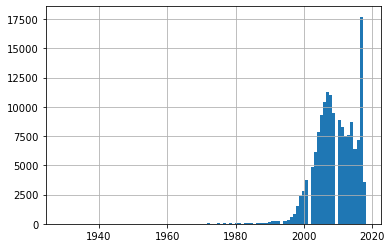

In [ ]:
df[ df["year_production"] != -1 ]["year_production"].hist(bins=100);

In [ ]:
feats = ["year_production"] + cat_feats

check_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(-10803.920571630824, 194.29319179542605)


Weight,Feature
0.2407,Napęd_cat
0.1388,year_production
0.0522,Przebieg_cat
0.0457,Pojemność skokowa_cat
0.0427,Moc_cat
0.0427,Serwisowany w ASO_cat
0.0400,Skrzynia biegów_cat
0.0380,Bezwypadkowy_cat
0.0356,Kod Silnika_cat
0.0339,Marka pojazdu_cat


In [ ]:
df['Pojemność skokowa']

0         1 199 cm3
1         1 598 cm3
2         1 364 cm3
3         1 798 cm3
4         1 250 cm3
            ...    
160245    2 000 cm3
160246      998 cm3
160247    1 600 cm3
160251    1 560 cm3
160254    3 301 cm3
Name: Pojemność skokowa, Length: 160257, dtype: object

In [ ]:
df['cubic_centimeter']=df['Pojemność skokowa'].map(lambda x: str(x).split("cm3")[0].replace(" ", "")).astype(int)

In [ ]:
df['cubic_centimeter']

0         1199
1         1598
2         1364
3         1798
4         1250
          ... 
160245    2000
160246     998
160247    1600
160251    1560
160254    3301
Name: cubic_centimeter, Length: 160257, dtype: int32

In [ ]:
df["cubic_centimeter"].describe()

count    1.602570e+05
mean     2.203297e+03
std      1.681123e+04
min     -1.000000e+00
25%      1.422000e+03
50%      1.800000e+03
75%      2.000000e+03
max      3.000218e+06
Name: cubic_centimeter, dtype: float64

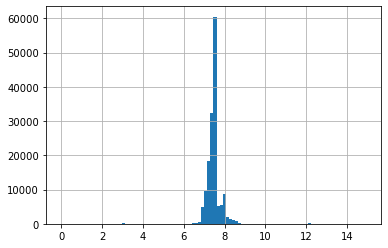

In [ ]:
df["cubic_centimeter_log"] = np.log(df["cubic_centimeter"])
df["cubic_centimeter_log"].hist(bins=100);

In [ ]:
feats = ["year_production"] + ['cubic_centimeter_log'] + cat_feats

check_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(-9804.382022755794, 287.66145218587695)


Weight,Feature
0.1709,year_production
0.1654,Napęd_cat
0.1390,Bezwypadkowy_cat
0.1099,cubic_centimeter_log
0.0392,Marka pojazdu_cat
0.0390,Skrzynia biegów_cat
0.0313,Przebieg_cat
0.0250,Stan_cat
0.0238,Uszkodzony_cat
0.0223,Kod Silnika_cat


In [ ]:
df['to_negotiate'] = df['price_details'].map(lambda x: 'do negocjacji' in str(x).lower())

df['to_negotiate'] = df['to_negotiate'].astype(int)

def check_brutto_netto(info):
    if 'brutto' in str(info).lower():
        return int(1)
    if 'netto' in str(info).lower():
        return int(0)
    else:
        return int(-1)

df['brutto_or_netto'] = df['price_details'].map(check_brutto_netto)

df['seller_type_cat'] = df['seller_type'].map(lambda x: x[0]).factorize()[0]

In [ ]:
feats = ['to_negotiate'] + ['brutto_or_netto'] + ['seller_type_cat'] + ["year_production"] + ['cubic_centimeter_log'] + cat_feats
check_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

C:\Users\48794\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\48794\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\48794\anaconda3\lib\site-packages\xgboost\core.py", line 506, in inner_f
    return f(**kwargs)
  File "C:\Users\48794\anaconda3\lib\site-packages\xgboost\sklearn.py", line 761, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "C:\Users\48794\anaconda3\lib\site-packages\xgboost\sklearn.py", line 286, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "C:\Users\48794\anaconda3\lib\site-packages\xgboost\sklearn.py", line 775, in <lambda>
    create_dmatrix=lambda **kwargs: DMatrix(nthread=self.n_jobs, **kwargs),
  Fil

ValueError: feature_names must be unique

In [ ]:
breadcrumbs = (
    df["breadcrumb"]
        .map(lambda x: {"breadcrumb_{}".format(idx): val for idx,val in enumerate(x) })
        .apply(pd.Series)
)
breadcrumbs = breadcrumbs.fillna(-1)

In [ ]:
breadcrumbs

,breadcrumb_0,breadcrumb_1,breadcrumb_2,breadcrumb_3,breadcrumb_4
0,Osobowe,Citroën,C4 Cactus,-1,-1
1,Osobowe,Nissan,Juke,-1,-1
2,Osobowe,Opel,Astra,Opel Astra H (2004-2014),-1
3,Osobowe,Audi,A4,Audi A4 B8 (2007-2015),-1
4,Osobowe,Ford,Fiesta,Ford Fiesta Mk7 (2008-),-1
...,...,...,...,...,...
160245,Osobowe,Volkswagen,Passat,Volkswagen Passat B7 (2010-2014),-1
160246,Osobowe,Citroën,C1,Citroën C1 II (2014-),-1
160247,Osobowe,Opel,Meriva,Opel Meriva I (2002-2010),-1
160251,Osobowe,Peugeot,207,-1,-1


In [ ]:
if 'breadcrumb_0' not in df:
    df = pd.concat([df, breadcrumbs], axis=1)
    
print(df.shape)
df.sample(5)

(160257, 175)


,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params,...,to_negotiate,brutto_or_netto,year_production,cubic_centimeter,cubic_centimeter_log,breadcrumb_0,breadcrumb_1,breadcrumb_2,breadcrumb_3,breadcrumb_4
65196,130439,"Cena Brutto, Faktura VAT",124100.0,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",Gołembiewscy,Dealer,"Gen. Stanisława Maczka 136 - 15-691 Białystok,...","[Osobowe, Mazda, 6, Mazda 6 III (2012-)]","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ...",...,0,1,2017,1998,7.599902,Osobowe,Mazda,6,Mazda 6 III (2012-),-1
61308,61308,NaN,NaN,NaN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Łomianki, warszawski zachodni, Mazowieckie","[Osobowe, Volkswagen, Caddy, Volkswagen Caddy ...","{'Pojemność skokowa': '1 400 cm3', 'Model poja...",...,0,-1,2008,1400,7.244228,Osobowe,Volkswagen,Caddy,Volkswagen Caddy III (2004-),-1
120395,120395,NaN,NaN,NaN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",Auto Handel,Dealer,"Szczebrzeska 47b - 22-400 Zamość, Lubelskie (P...","[Osobowe, Volkswagen, Passat, Volkswagen Passa...","{'Pojemność skokowa': '1 900 cm3', 'Model poja...",...,0,-1,1999,1900,7.549609,Osobowe,Volkswagen,Passat,Volkswagen Passat B5 FL (2000-2005),-1
89175,89175,NaN,NaN,NaN,"[ABS, Elektrycznie ustawiane lusterka, Poduszk...",Autoryzowany Dealer Skody GALL-ICM WROCŁAW,Dealer,"Armi Krajowej 46 - 50-541 Wrocław, Krzyki (Pol...","[Osobowe, Škoda, Octavia, Škoda Octavia III (2...","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ...",...,0,-1,2017,2000,7.600902,Osobowe,Škoda,Octavia,Škoda Octavia III (2013-),-1
52536,52536,NaN,NaN,NaN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",Cramer,Dealer,"Chojnicka 15 - 77-400 Złotów, złotowski, Wielk...","[Osobowe, Suzuki, Swift, Suzuki Swift V (2010-...","{'Kolor': 'Czerwony', 'Model pojazdu': 'Swift'...",...,0,-1,2010,-1,NaN,Osobowe,Suzuki,Swift,Suzuki Swift V (2010-2017),-1


In [ ]:
for i in breadcrumbs.columns:
    df[i] = df[i].factorize()[0]
df.head()

,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params,...,to_negotiate,brutto_or_netto,year_production,cubic_centimeter,cubic_centimeter_log,breadcrumb_0,breadcrumb_1,breadcrumb_2,breadcrumb_3,breadcrumb_4
0,7,"Cena Brutto, Faktura VAT",63900.0,PLN,"[ABS, Elektrycznie ustawiane lusterka, Poduszk...",TRANS-AUTO SP. Z O.O. DEALER MARKI ...,Dealer,"ŁUKASIEWICZA 1 - 19-300 Ełk, ełcki, Warmińsko-...","[Osobowe, Citroën, C4 Cactus]","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ...",...,0,1,2017,1199,7.089243,0,0,0,0,0
1,10,Cena Brutto,41900.0,PLN,"[ABS, ASR (kontrola trakcji), Elektryczne szyb...",DECAR - RENAULT i DACIA,Dealer,"MODLIŃSKA 154 B - 03-170 Warszawa, Mazowieckie...","[Osobowe, Nissan, Juke]","{'Kolor': 'Czarny', 'Model pojazdu': 'Juke', '...",...,0,1,2012,1598,7.376508,0,1,1,0,0
2,11,"Cena Brutto, Do negocjacji",17950.0,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",SKUP SPRZEDAŻ ZAMIANA RATY,Dealer,"Ruchocinek 63c - 62-230 Witkowo, gnieźnieński,...","[Osobowe, Opel, Astra, Opel Astra H (2004-2014)]","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ...",...,1,1,2008,1364,7.218177,0,2,2,1,0
3,14,"Cena Brutto, Do negocjacji",38000.0,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Chróścice, opolski, Opolskie","[Osobowe, Audi, A4, Audi A4 B8 (2007-2015)]","{'Liczba miejsc': '5', 'Kraj pochodzenia': 'Ni...",...,1,1,2008,1798,7.494430,0,3,3,2,0
4,16,Cena Brutto,21900.0,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Trzeboszowice, nyski, Opolskie","[Osobowe, Ford, Fiesta, Ford Fiesta Mk7 (2008-)]","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ...",...,0,1,2010,1250,7.130899,0,4,4,3,0


In [ ]:
breadcrumbs_list = []
for i in breadcrumbs.columns:
    breadcrumbs_list.append(i)

In [ ]:
feats = ['year_production'] + ['cubic_centimeter_log'] + cat_feats + breadcrumbs_list
check_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(-9691.542866095147, 242.00669206147788)


Weight,Feature
0.1619,year_production
0.1381,Napęd_cat
0.1246,cubic_centimeter_log
0.1157,Bezwypadkowy_cat
0.0478,Marka pojazdu_cat
0.0378,Stan_cat
0.0297,Skrzynia biegów_cat
0.0290,Przebieg_cat
0.0255,Kod Silnika_cat
0.0215,Faktura VAT_cat


In [ ]:
df['voivodship'] = df['seller_address'].map(lambda x: x.replace(' ', '').split(','))
voivodships = ['zachodnio-pomorskie', 'pomorskie', 'warmińsko-mazurskie', 'podlaskie', 'lubelskie', 'podkarpackie', 'małopolskie', 'śląskie', 'opolskie', 'dolnośląskie', 'lubuskie', 'kujawsko-pomorskie', 'wielkopolskie', 'mazowieckie', 'łódzkie', 'świętokrzyskie']

In [ ]:
def check_voivodship(info):
    voivodship = -1
    for i in info:
        for j in voivodships:
            if i.lower() == j:
                voivodship = j
    return voivodship

In [ ]:
df['voivodship'] = df['voivodship'].map(check_voivodship)

In [ ]:
df['voivodship'].unique()

array([-1, 'opolskie', 'podkarpackie', 'pomorskie', 'śląskie', 'łódzkie',
       'podlaskie', 'świętokrzyskie', 'kujawsko-pomorskie', 'mazowieckie',
       'małopolskie', 'lubelskie', 'wielkopolskie', 'dolnośląskie',
       'lubuskie', 'warmińsko-mazurskie'], dtype=object)

In [ ]:
df['voivodship'] = df['voivodship'].factorize()[0]

In [ ]:
feats = ["year_production"] + ['cubic_centimeter_log'] + ['voivodship'] + cat_feats + breadcrumbs_list 
check_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(-9722.998904232616, 268.6254157095219)


Weight,Feature
0.1512,Napęd_cat
0.1429,year_production
0.1264,Bezwypadkowy_cat
0.1179,cubic_centimeter_log
0.0473,Marka pojazdu_cat
0.0415,voivodship
0.0351,Stan_cat
0.0314,Skrzynia biegów_cat
0.0241,Kod Silnika_cat
0.0229,Faktura VAT_cat


In [ ]:
df['Pierwsza rejestracja'].unique()

array(['15 listopad 2017', '15 czerwiec 2012', -1, ..., '08 marzec 2011',
       'czerwiec 2001', '17 kwiecień 2004'], dtype=object)

In [ ]:
def get_year_registration(info):
    if info == -1:
        return -1
    else:
        info.replace(' ', '')
        info = info[-4:]
        return info

In [ ]:
df['first_registration'] = df['Pierwsza rejestracja'].map(get_year_registration).astype(int)

In [ ]:
feats = ['first_registration'] + ["year_production"] + ['cubic_centimeter_log'] + ['voivodship'] + cat_feats + breadcrumbs_list 
check_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(-9725.175407592551, 250.0922960147338)


Weight,Feature
0.1533,year_production
0.1528,Napęd_cat
0.1134,cubic_centimeter_log
0.1096,Bezwypadkowy_cat
0.0498,voivodship
0.0435,Marka pojazdu_cat
0.0325,Skrzynia biegów_cat
0.0305,Stan_cat
0.0249,Kod Silnika_cat
0.0226,Faktura VAT_cat


In [ ]:
df['mileage'] = df['Przebieg'].map(lambda x: str(x).replace(' ', '').split('km')[0])
df['mileage'] = df['mileage'].astype(int)

<AxesSubplot:>

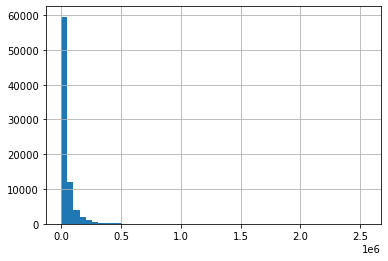

In [ ]:
df[ df["price_value"].notnull() ]["price_value"].hist(bins=50)

<AxesSubplot:>

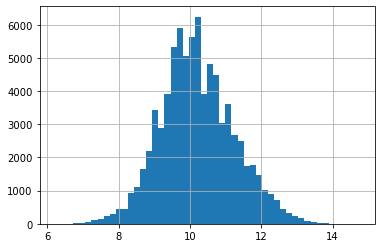

In [ ]:
np.log(df[ df["price_value"].notnull() ]["price_value"]).hist(bins=50)

In [ ]:
def check_log_model(df, feats, model, cv=4, scoring=mean_absolute_error, show_eli5=True):
    df_train = df[ ~df["price_value"].isnull() ].copy()

    X = df_train[feats]
    y = df_train["price_value"]
    y_log = np.log(y)
    
    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores = []
    for train_idx, test_idx in tqdm(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)

        
        score = scoring(y_test, y_pred)
        scores.append(score)
        
    result = np.mean(scores), np.std(scores)
    
    if show_eli5:
        model.fit(X, y_log)
        print(result)
        return eli5.show_weights(model, feature_names=feats)

    return result

In [ ]:
feats = ['mileage'] + ['first_registration'] + ["year_production"] + ['cubic_centimeter_log'] + ['voivodship'] + cat_feats + breadcrumbs_list 
check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

4it [00:18,  4.64s/it]


(9231.519251159021, 98.53162345126297)


Weight,Feature
0.3371,year_production
0.1704,Napęd_cat
0.1088,Skrzynia biegów_cat
0.0447,Możliwość finansowania_cat
0.0295,cubic_centimeter_log
0.0280,Uszkodzony_cat
0.0261,Serwisowany w ASO_cat
0.0259,Bezwypadkowy_cat
0.0225,Faktura VAT_cat
0.0200,Kierownica po prawej (Anglik)_cat


In [ ]:
df['power'] = df['Moc'].map(lambda x: str(x).replace(' ', '').split('KM')[0])
df['power'] = df['power'].astype(int)

In [ ]:
feats = ['power'] + ['mileage'] + ['first_registration'] + ["year_production"] + ['cubic_centimeter_log'] + ['voivodship'] + cat_feats + breadcrumbs_list 
check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

4it [00:18,  4.60s/it]


(8537.340140052162, 129.36382607501662)


Weight,Feature
0.4111,year_production
0.0917,power
0.0832,Skrzynia biegów_cat
0.0640,Napęd_cat
0.0334,Serwisowany w ASO_cat
0.0274,Uszkodzony_cat
0.0240,mileage
0.0216,Kierownica po prawej (Anglik)_cat
0.0203,Bezwypadkowy_cat
0.0191,cubic_centimeter_log


In [ ]:
df['monthly_rate'] = df['Miesięczna rata'].map(lambda x: str(x).split('PLN')[0])
df["monthly_rate"] = df['monthly_rate'].str.replace(' ', '').str.replace(',', '.').astype(float)
df['monthly_rate'] = df['monthly_rate'].map(lambda x: np.log(x))

C:\Users\48794\AppData\Local\Temp/ipykernel_2000/3345202677.py:3: RuntimeWarning: invalid value encountered in log
  df['monthly_rate'] = df['monthly_rate'].map(lambda x: np.log(x))


In [ ]:
feats = ['monthly_rate'] + ['power'] + ['mileage'] + ['first_registration'] + ["year_production"] + ['cubic_centimeter_log'] + ['voivodship'] + cat_feats + breadcrumbs_list 
check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

4it [00:18,  4.58s/it]


(8521.270650214663, 79.79809914013822)


Weight,Feature
0.4127,year_production
0.1020,Skrzynia biegów_cat
0.0900,power
0.0778,Napęd_cat
0.0424,Bezwypadkowy_cat
0.0228,mileage
0.0227,Uszkodzony_cat
0.0198,cubic_centimeter_log
0.0178,Kierownica po prawej (Anglik)_cat
0.0142,Serwisowany w ASO_cat


In [ ]:
df['Engine capacity'].unique()
df['capacity_engine'] = df['Engine capacity'].map(lambda x: str(x).replace(' ', '').split('cm3')[0]).astype(int)
df['capacity_engine'].unique()

array([  -1, 1598, 2200, 1600, 2000, 1956, 1395, 3600, 1499, 1975,  999,
       4463, 1896, 2953, 1242, 1100, 1364, 1995, 1968, 1400, 1248, 3000,
       1997, 1910, 1500,  998, 2698, 1998, 1498, 2400, 1587, 1300, 1800,
       1999, 2500, 1686, 1461, 2497, 1595, 1124, 2143, 2231, 1200, 2198,
       1700])

In [ ]:
feats = ['capacity_engine'] + ['monthly_rate'] + ['power'] + ['mileage'] + ['first_registration'] + ["year_production"] + ['cubic_centimeter_log'] + ['voivodship'] + cat_feats + breadcrumbs_list 
check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

4it [00:20,  5.03s/it]


(8516.428331135454, 63.715123331356544)


Weight,Feature
0.4121,year_production
0.1018,Skrzynia biegów_cat
0.0898,power
0.0777,Napęd_cat
0.0423,Bezwypadkowy_cat
0.0228,mileage
0.0226,Uszkodzony_cat
0.0198,cubic_centimeter_log
0.0178,Kierownica po prawej (Anglik)_cat
0.0142,Serwisowany w ASO_cat
